In [1]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(10)
#stl_filename = "/Users/ecordina/Desktop/je/STL-segmentation/OrthoCAD_Export_43495989/43495989_shell_occlusion_l.stl"
stl_filename = r"C:\Users\Emman\Desktop\JE\Ortho\STL-Segmentation\OrthoCAD_Export_43495989\43495989_shell_occlusion_l.stl"
mesh=trimesh.load(stl_filename)

In [3]:
mesh.show()

In [2]:
def getCluster(data,label,label_number):
    center=[]
    for k in range(len(label)):
        if label[k]==label_number:
            center.append(data[k])
    if len(center)!=0:
        return np.array(center),np.mean(center,axis=0)
    return np.array([]),0

def getAllClustersCenters(data,clustering):
    centers=[]
    for i in np.unique(clustering.labels_):
        _,mean_=getCluster(data,clustering.labels_,i)
        centers.append(mean_)
    return centers

In [16]:
from shapely import hausdorff_distance,area,distance
from shapely import MultiPoint
from tqdm import tqdm
from scipy.spatial.distance import cdist,euclidean
from scipy.spatial.distance import squareform

# def distance(res,res_1):
#     p=MultiPoint(res)
#     return p.distance(MultiPoint(res_1))/p.convex_hull.area
def distance(res,res_1):
    p=np.mean(res,axis=0)
    p1=np.mean(res_1,axis=0)
    print(p),print(p1)
    return euclidean(p,p1)

def joinClusters(kmeans,kmeans_1,data_1,thresh=7):
    centers=kmeans.cluster_centers_
    try:
        centers_1=kmeans_1.cluster_centers_
    except AttributeError:
        centers_1=getAllClustersCenters(data_1,kmeans_1)
    list_distance=[]
    for center in centers:
        distance_list=[]
        for center_1 in centers_1:
            dist=euclidean(center,center_1)
            if dist!=dist:
                distance_list.append(10_000)
            else:
                distance_list.append(dist)
        list_distance.append(distance_list)
    
    matrix_2=[np.argmin(elem) for elem in list_distance]
    res=[np.min(elem) for elem in list_distance]
    if (np.array(res)>thresh).any():
        new_value=[]
        for point in np.where(np.array(res)>thresh)[0]:
            try:
                new_value_temp=len(np.unique(kmeans_1.labels_))-1+np.argmin(list_distance[point][len(np.unique(kmeans_1.labels_)):])
            except ValueError:
                new_value_temp=len(np.unique(kmeans_1.labels_))-1
            while new_value_temp in matrix_2:
                new_value_temp+=1
            matrix_2[point]=new_value_temp
            new_value.append(new_value_temp)
    new_labels=[matrix_2[label] for label in kmeans.labels_]
    #assert(len(new_labels)==len(kmeans.labels_))
    bool_arr=[label in matrix_2 for label in np.unique(kmeans.labels_)]
    kmeans.labels_=new_labels
    kmeans.cluster_centers_=kmeans.cluster_centers_[bool_arr]
    # assert(len(np.unique(new_labels))==len(kmeans.cluster_centers_))
    return list_distance,kmeans,np.array(new_labels)


def add_clusters(X,kmean,dist_max=9):
    center_2=list(kmean.cluster_centers_).copy()
    for i in np.unique(kmean.labels_):
        res=getCluster(X,kmean.labels_,i)[0]
        dist=cdist(res,[kmean.cluster_centers_[i]],metric='cityblock')
        test=res[np.where(dist>10)[0]]
        if len(test>0):
            me=np.mean(test,axis=0)
            center_2.append(me)
    kmean = KMeans(n_clusters=len(center_2),random_state=0, init=center_2,n_init="auto").fit(X)
    center_2=list(center_2)
    for i in np.unique(kmean.labels_):
        res=getCluster(X,kmean.labels_,i)[0]
        dist=cdist(res,[kmean.cluster_centers_[i]],metric='cityblock')
        test=res[np.where(dist>dist_max)[0]]
        if len(test>0):
            me=np.mean(test,axis=0)
            center_2.append(me)
    center_2=np.array(center_2)
    kmean = KMeans(n_clusters=len(center_2),random_state=0, init=center_2,n_init="auto").fit(X)
    return kmean


def getCloseClusters(kmeans):
    test=np.array(np.where((squareform(pdist(kmeans.cluster_centers_))<6)*(squareform(pdist(kmeans.cluster_centers_))!=0)))
    res=[]
    for x in test.T:
        if x not in np.array(res) and [x[1],x[0]] not in np.array(res):
            res.append(x)
    res=np.array(res)
    return res

def joinClusters2(kmeans):
    idx_close=getCloseClusters(kmeans)
    res=[]
    done=[]
    centers=kmeans.cluster_centers_
    for i in range(len(centers)):
        if i not in idx_close:
            res.append(centers[i])
        elif i not in done:
            center_one=centers[idx_close[np.where(idx_close==i)[0][0]][0]]
            center_two=centers[idx_close[np.where(idx_close==i)[0][0]][1]]
            res.append((center_one+center_two)/2)
            done.append(idx_close[np.where(idx_close==i)[0][0]][0])
            done.append(idx_close[np.where(idx_close==i)[0][0]][1])
    return np.array(res)

In [4]:
import pandas as pd
from itertools import cycle

In [5]:
def to_df(z_slice,kmeans):
    return pd.DataFrame({'x':z_slice[:,0],'y':z_slice[:,1],'label':kmeans.labels_})

In [6]:
    # Define a set of distinct colors (you can extend this list if needed)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
            '#ff9896', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896',
            '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d',
            '#9edae5', '#ad494a', '#8c6d31', '#aec7e8', '#ffbb78',"#fff751"]
label_color_map = dict(zip(list(range(26)), cycle(colors)))

In [7]:
#df=pd.DataFrame({'x':z_slice[-i-1][:,0],'y':z_slice[-i-1][:,1],'label':list_kmeans[i].labels_})


def plotting(z_slice,kmeans,i):
    df=to_df(z_slice[-i-1],kmeans[i])

    # Mapping labels to colors
    label_color_map_unique={}
    for key in label_color_map.keys():
        if key in df['label'].unique():
            label_color_map_unique[key]=label_color_map[key]
    # Plotting scatter plot with colors
    for label, color in label_color_map_unique.items():
        plt.scatter(df[df['label'] == label]['x'], df[df['label'] == label]['y'], label=label, color=color)
    # Adding legend
    plt.legend()
    # Adding labels
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Scatter Plot with Labels Colored')
    # Showing the plot
    plt.show()
def plotting_df(df):

    # Mapping labels to colors
    label_color_map_unique={}
    for key in label_color_map.keys():
        if key in df['label'].unique():
            label_color_map_unique[key]=label_color_map[key]
    # Plotting scatter plot with colors
    for label, color in label_color_map_unique.items():
        plt.scatter(df[df['label'] == label]['x'], df[df['label'] == label]['y'], label=label, color=color)
    # Adding legend
    plt.legend()
    # Adding labels
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Scatter Plot with Labels Colored')
    # Showing the plot
    plt.show()

In [8]:
import stltovoxel
import numpy as np
import matplotlib.pyplot as plt
stl_filename = r"C:\Users\Emman\Desktop\JE\Ortho\STL-Segmentation\OrthoCAD_Export_43495989\43495989_shell_occlusion_l.stl"
input=stl_filename
output=stl_filename[:-3]+"npy"
stltovoxel.convert_file(input, output, voxel_size=0.1)

Processing layer 0/320
Processing layer 1/320
Processing layer 2/320
Processing layer 3/320
Processing layer 4/320
Processing layer 5/320
Processing layer 6/320
Processing layer 7/320
Processing layer 8/320
Processing layer 9/320
Processing layer 10/320
Processing layer 11/320
Processing layer 12/320
Processing layer 13/320
Processing layer 14/320
Processing layer 15/320
Processing layer 16/320
Processing layer 17/320
Processing layer 18/320
Processing layer 19/320
Processing layer 20/320
Processing layer 21/320
Processing layer 22/320
Processing layer 23/320
Processing layer 24/320
Processing layer 25/320
Processing layer 26/320
Processing layer 27/320
Processing layer 28/320
Processing layer 29/320
Processing layer 30/320
Processing layer 31/320
Processing layer 32/320
Processing layer 33/320
Processing layer 34/320
Processing layer 35/320
Processing layer 36/320
Processing layer 37/320
Processing layer 38/320
Processing layer 39/320
Processing layer 40/320
Processing layer 41/320
Pr

In [9]:
import numpy as np
import matplotlib.pyplot as plt
stl_filename = r"C:\Users\Emman\Desktop\JE\Ortho\STL-Segmentation\OrthoCAD_Export_43495989\43495989_shell_occlusion_l.stl"
voxel=np.load(stl_filename[:-3]+"npy")
voxel2=voxel[voxel[:,2]<31]
voxel2=voxel2[voxel2[:,2]>24]
voxel2=np.unique(voxel2,axis=0)
len(voxel),len(voxel2)
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(voxel2[:,0],voxel2[:,1],voxel2[:,2])

(68057234, 3796414)

In [10]:
z_slice=[]
for z in np.unique(voxel2[:,2]):
    t=voxel[voxel[:,2]==z][:,:-1]
    if len(t)>10:
        z_slice.append(t)

In [17]:
from tqdm import tqdm
from sklearn.cluster import SpectralClustering,KMeans
from copy import deepcopy
X = z_slice[-1].copy()
kmeans_init = SpectralClustering(n_clusters=8).fit(X)
centers=getAllClustersCenters(X,kmeans_init)
list_kmeans=[kmeans_init]
list_centers=[centers]
X_1=X.copy()
kmeans_1=deepcopy(kmeans_init)
for i in tqdm(range(2,len(z_slice))):
    X=z_slice[-i].copy()
    n_clusters=len(list_centers[i-2])
    kmeans = KMeans(n_clusters=n_clusters, random_state=0,init=list_centers[i-2],n_init="auto").fit(X)
    kmean___=add_clusters(X,kmeans,dist_max=8)
    list_centers.append(getAllClustersCenters(X,kmean___))
    list_kmeans.append(kmean___)
    X_1=X.copy()
    kmeans_1=deepcopy(kmeans)
    

100%|██████████| 68/68 [01:54<00:00,  1.68s/it]


In [18]:
i=0
X_1=z_slice[-i-1]
kmeans_1=list_kmeans[i]
df=pd.DataFrame({'x':X_1[:,0],'y':X_1[:,1],'z':len(z_slice)*np.ones_like(X_1[:,1]),'label':np.array(kmeans_1.labels_)})
for i in tqdm(range(1,len(z_slice)-1)):
    X_1=z_slice[-i]
    kmeans_1=list_kmeans[i-1]
    X=z_slice[-i-1]
    kmean=list_kmeans[i]
    list_distance,kmean,newlabels_=joinClusters(kmean,kmeans_1,X_1)
    list_kmeans[i]=kmean
    df2=pd.DataFrame({'x':X[:,0],'y':X[:,1],'z':(len(z_slice)-i)*np.ones_like(X[:,1]),'label':kmean.labels_})
    df=pd.concat([df,df2],ignore_index=True)

100%|██████████| 68/68 [00:26<00:00,  2.53it/s]


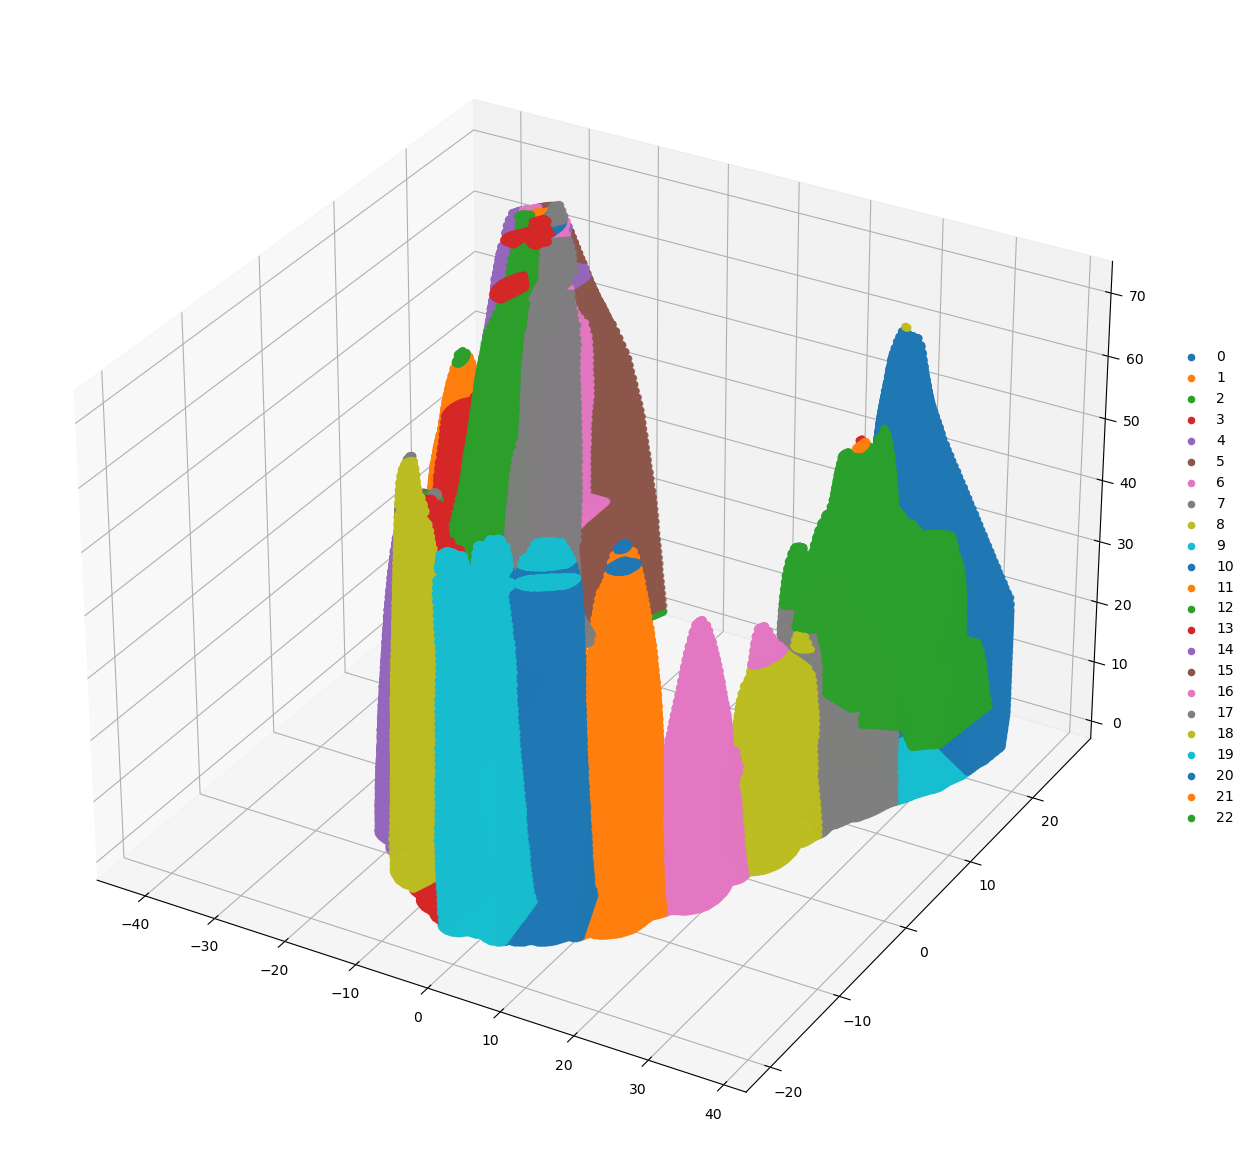

In [19]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')

for grp_name, grp_idx in df.groupby('label').groups.items():
    y = df.iloc[grp_idx,1]
    x = df.iloc[grp_idx,0]
    z = df.iloc[grp_idx,2]
    ax.scatter(x, y, z, label=grp_name)  # this way you can control color/marker/size of each group freely
    #ax.scatter(*df.iloc[grp_idx, [0, 1, 2]].T.values, label=grp_name)  # if you want to do everything in one line, lol

ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
plt.show()

In [32]:
df.to_csv(r"C:\Users\Emman\Desktop\JE\Ortho\STL-Segmentation\OrthoCAD_Export_43495989\clustered.csv")

In [1]:
import pandas as pd
df=pd.read_csv(r"C:\Users\Emman\Desktop\JE\Ortho\STL-Segmentation\OrthoCAD_Export_43495989\clustered.csv")

In [2]:
points=df.to_numpy()[:,:3].astype(float)

In [6]:
import numpy as np
import pyvista as pv

# points is a 3D numpy array (n_points, 3) coordinates of a sphere
# cloud = pv.PolyData(points)
# cloud.plot()

# volume = cloud.delaunay_3d(alpha=2.)
# shell = volume.extract_geometry()
# shell.plot()

In [7]:
cloud = pv.PolyData(points)
surf = cloud.reconstruct_surface(progress_bar=True)
pl = pv.Plotter(shape=(1, 2))
_ = pl.add_mesh(cloud)
_ = pl.add_title('Point Cloud of 3D Surface')
pl.subplot(0, 1)
_ = pl.add_mesh(surf, color=True, show_edges=True)
_ = pl.add_title('Reconstructed Surface')
pl.show()

  0%|          [00:00<?]

In [ ]:
# 3D Plotting
# import plotly.express as px
# df['color']=[label_color_map[label] for label in df['label']]
# fig = px.scatter_3d(
#     df, x="x", y="y", z="z", labels="label",color='color'
# )
# fig.show()